In [42]:
# Requiered imports
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


# 1. Dataset Description

The dataset amazon.csv from Kaggle (https://www.kaggle.com/datasets/mahmudulhaqueshawon/amazon-product-reviews) contains customer reviews from Amazon, along with a sentiment label for each review. It consists of approximately 20,000 entries, with two columns: Text (the review content) and label (the sentiment, where 1 typically represents positive and 0 represents negative).

In [25]:
# Load the dataset
df = pd.read_csv('../data/amazon.csv')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    19996 non-null  object
 1   label   19996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


# 2. Text Pre-Processing

In [27]:
# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [28]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text) # Keep square brackets for now, will remove if needed later.
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(processed_tokens)

In [29]:
# Apply preprocessing
df['processed_text'] = df['Text'].apply(preprocess_text)

# 3. Data Exploration 

### a. Sentiment Distribution
The initial sentiment distribution in the dataset is as follows:

In [30]:
# Sentiment Distribution Analysis
sentiment_counts = df["label"].value_counts()

# Map numerical labels to sentiment names for better readability
sentiment_mapping = {1: "Positive", 0: "Negative"}
df["sentiment"] = df["label"].map(sentiment_mapping)
sentiment_counts_named = df["sentiment"].value_counts()
print(sentiment_counts_named)


sentiment
Positive    15230
Negative     4766
Name: count, dtype: int64


This indicates a significant imbalance, with a much larger number of positive reviews compared to negative ones.

### b. Visualizations

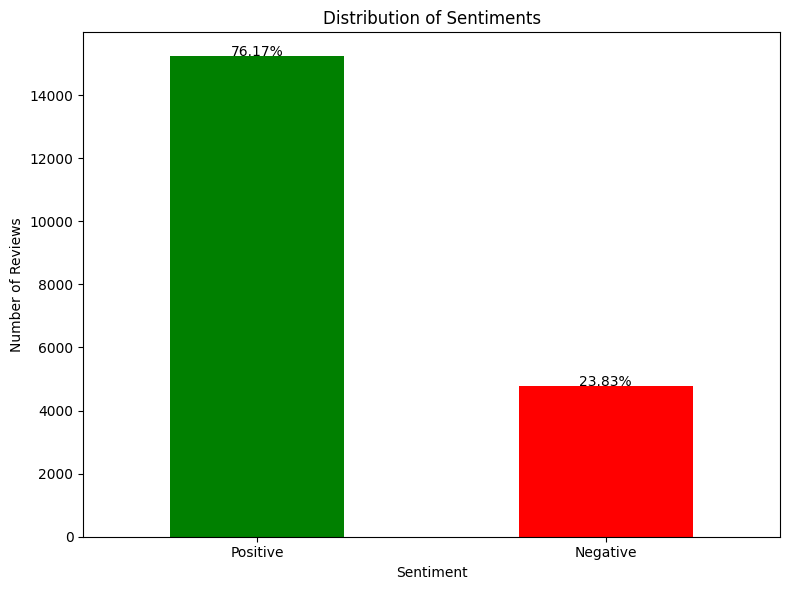

In [ ]:
# Sentiment Distribution bar chart
plt.figure(figsize=(8, 6))
sentiment_counts_named.plot(kind="bar", color=["green", "red"])
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.tight_layout()

# Sentiment Distribution Percentages

for i, count in enumerate(sentiment_counts_named):
    plt.text(i, count, f"{(count / len(df) * 100):.2f}%", ha='center')


### c. Insights from data exploration
- The dataset is heavily skewed towards positive reviews, which is common in many product review datasets. This imbalance needs to be considered during model training and evaluation.

# 4. Sentiment Analysis

- **Lexicon based method**

In [38]:
nltk.download("vader_lexicon")
sid = SentimentIntensityAnalyzer()

df["vader_prediction"] = df["processed_text"].apply(lambda x: sid.polarity_scores(x))
df["vader_prediction"].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\57317\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0    {'neg': 0.153, 'neu': 0.526, 'pos': 0.321, 'co...
1    {'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'comp...
2    {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'comp...
3    {'neg': 0.154, 'neu': 0.16, 'pos': 0.686, 'com...
4    {'neg': 0.0, 'neu': 0.286, 'pos': 0.714, 'comp...
Name: vader_prediction, dtype: object

- **Naive Bayes**

In [39]:
# Prepare data for ML model
X = df["processed_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000) # Limit features to manage complexity
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [50]:
# model training
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [51]:
# Predict and evaluate
nb_predictions = nb_model.predict(X_test_tfidf)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions, labels=[0, 1], target_names=["Negative", "Positive"]))

Naive Bayes Accuracy: 0.8528
Naive Bayes Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.44      0.59       978
    Positive       0.84      0.99      0.91      3022

    accuracy                           0.85      4000
   macro avg       0.88      0.71      0.75      4000
weighted avg       0.86      0.85      0.83      4000

